In [90]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.special import gamma
from matplotlib.collections import LineCollection

eps = 10**(-4)
G = 6.67e-11
A_NFW = 4.625
f_b = 0.16 # baryon fraction 
sigma_T = 6.6525e-29  # thomson cross-section
m_e = 9.1094e-31
c = 2.9979e8
mu = 0.6
mu_e = 1.14  # mean electron molecular weight
k_B = 1.38e-23  # boltzmann constant in J/K

In [92]:
z = 1

hubble_factor = 1/(1+z)

H_0 = 2.27e-18

H = H_0 * np.sqrt(1e-3 * hubble_factor**(-4) + 0.3 * hubble_factor**(-3) + 0 * hubble_factor**(-2) + 0.7)

print(H)

M_halo = 1e15 * 2e30 #kg
G = 6.67e-11

rho_cr = 3 * H**2 / (8 * np.pi * G)

Delta = 200

r_halo = (2*G*M_halo / (H**2 * Delta))**(1/3)

vc2_halo = G * M_halo / r_halo

print('The halo radius is', r_halo / 3.086e19, 'kpc')
print('The halo circular velocity is', np.sqrt(vc2_halo)/1e3, 'km/s')

def vc2_NFW_template(x):
    return A_NFW * (np.log(1+x) / x - 1 / (1+x))

ratio_point = 10

halo_vc2_ratio = vc2_NFW_template(ratio_point)

vphi2 = vc2_halo / halo_vc2_ratio

print('The maximum circular velocity is', np.sqrt(vphi2)/1e3, 'km/s')

4.007048340112706e-18
The halo radius is 1413.9681718000284 kpc
The halo circular velocity is 1748.4778585507963 km/s
The maximum circular velocity is 2107.1014794419784 km/s


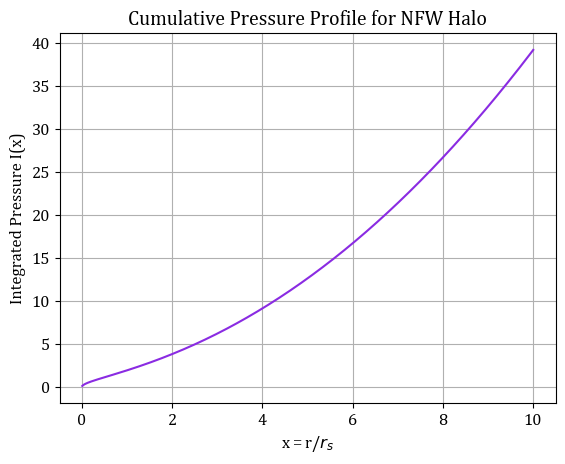

In [108]:
x_values = np.linspace(0.01, 10, 500)

rmax = 2.16258

def alpha(x):
    return 1.5

def integrandf_P(t):
    return alpha(t) / t

def f_P(x):        
    resultf_P, _ = integrate.quad(integrandf_P, 1+eps, x, limit=500)
    return np.exp(-resultf_P)

def v2_NFW(x):
    return A_NFW * vphi2 * (np.log(1+x) / x - 1 / (1+x))

def integrandI(t):
    return vphi2 * alpha(t) * f_P(t) * t**2 / (v2_NFW(t))

def I(x):        
    resultI, _ = integrate.quad(integrandI, eps, x, limit=50)
    return resultI

I_vec = np.vectorize(I)
y_I = I_vec(x_values)

cfont = {'fontname':'cambria'}

#plt.xscale('log')
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12    
plt.plot(x_values, y_I, color='blueviolet')
plt.title('Cumulative Pressure Profile for NFW Halo', **cfont)
plt.xlabel('x = r/$r_{s}$',  **cfont)
plt.ylabel('Integrated Pressure I(x)',  **cfont)
plt.grid(True)

In [95]:
M_CGM = f_b * M_halo

r_0 = r_halo / ratio_point

P_0 = M_CGM * vphi2 / (4*np.pi * r_0**3 * I(r_halo/r_0))

print('$P_0$:', P_0)

def rho(r):
    return P_0 * alpha(r/r_0) * f_P(r/r_0) / v2_NFW(r/r_0)

def P(r):
    return P_0 * f_P(r/r_0)

$P_0$: 3.473957191394522e-11


In [96]:
alpha_val = 1.5

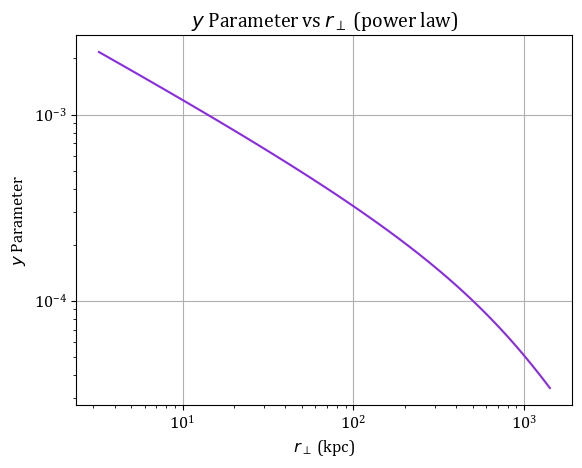

In [97]:
def y_parameter(r_perp):
    def integrand(r_parallel):
        r = np.sqrt(r_perp**2 + r_parallel**2)
        return f_P(r/r_0)
    
    integral, _ = integrate.quad(integrand, 0, r_halo, limit=500)
    coeff = (2 * P_0 * mu * sigma_T) / (mu_e * m_e * c**2)
    return coeff * integral

r_perp_values = np.logspace(20, np.log10(r_halo), 100)
y_values = np.vectorize(y_parameter)(r_perp_values)
r_perp_values_kpc = r_perp_values / 3.086e19

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(r_perp_values_kpc, y_values, color='blueviolet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_\\perp$ (kpc)')
plt.ylabel('$y$ Parameter')
plt.title('$y$ Parameter vs $r_\\perp$ (power law)')
plt.grid()
plt.show()

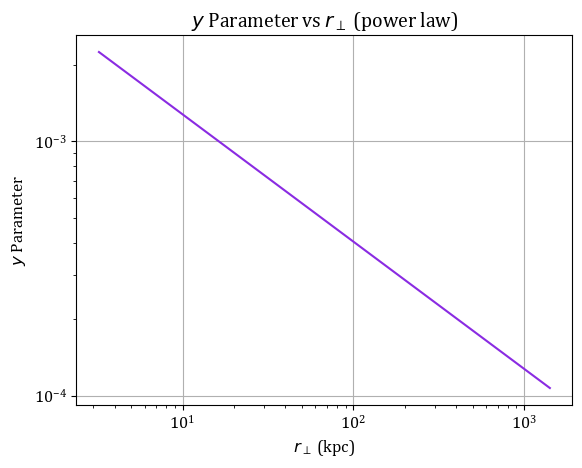

In [98]:
def y_parameter_power_law(r_perp):
    coeff_1 = (mu * sigma_T) / (mu_e * m_e * c**2)
    coeff_2 = (np.pi**(0.5) * gamma((alpha_val - 1)/2)) / (gamma(alpha_val/2))
    result = coeff_1 * coeff_2 * r_0 * P_0 * (r_perp / r_0)**(1 - alpha_val)
    return result

y_values_power_law = np.vectorize(y_parameter_power_law)(r_perp_values)

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.plot(r_perp_values_kpc, y_values_power_law, color='blueviolet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$r_\\perp$ (kpc)')
plt.ylabel('$y$ Parameter')
plt.title('$y$ Parameter vs $r_\\perp$ (power law)')
plt.grid()
plt.show()

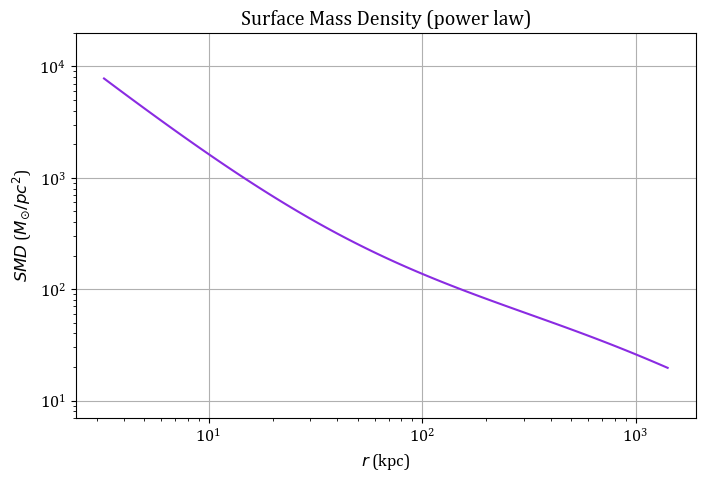

In [99]:
def SMD(r_perp):
    def integrand(r_parallel):
        r = np.sqrt(r_perp**2 + r_parallel**2)
        return rho(r) 

    result, _ = integrate.quad(integrand, 0, r_halo, limit=500)
    
    return 2 * result

SMD_1_values = np.vectorize(SMD)(r_perp_values)
SMD_1_values_Msunpc2 = SMD_1_values * 476.1698

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.figure(figsize=(8, 5))
plt.plot(r_perp_values_kpc, SMD_1_values_Msunpc2, color='blueviolet')
plt.xlabel(r'$r$ (kpc)')
plt.ylabel(r'$SMD$ ($M_{\odot} / pc^2$)')
plt.title('Surface Mass Density (power law)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(7e0, 2e4)
plt.grid()

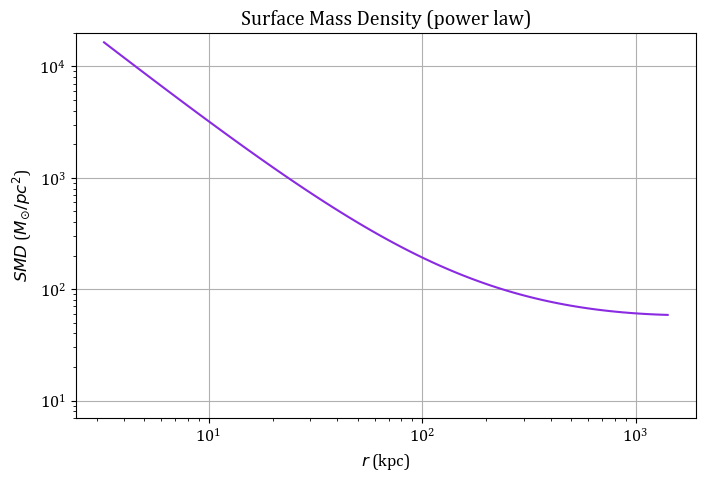

In [100]:
def SMD_power_law(r_perp):
    coeff = (np.pi**(0.5) * gamma((alpha_val - 1)/2)) / (gamma(alpha_val/2))
    result = coeff * r_perp * rho(r_perp)
    return result

SMD_1_values_power_law = np.vectorize(SMD_power_law)(r_perp_values)
SMD_1_values_power_law_Msunpc2 = SMD_1_values_power_law * 476.1698

cfont = {'fontname':'cambria'}
plt.rcParams['font.family'] = 'cambria' 
plt.rcParams['font.size'] = 12  
plt.figure(figsize=(8, 5))
plt.plot(r_perp_values_kpc, SMD_1_values_power_law_Msunpc2, color='blueviolet')
plt.xlabel(r'$r$ (kpc)')
plt.ylabel(r'$SMD$ ($M_{\odot} / pc^2$)')
plt.title('Surface Mass Density (power law)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(7e0, 2e4)
plt.grid()